In [1]:
import numpy as np
import tensorflow as tf
from keras import Model, layers, optimizers
import random
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import pygame
import numpy as np
from Core_Game_Parts import *
import os 

pygame 2.6.1 (SDL 2.28.4, Python 3.13.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


c:\Users\Yash\OneDrive\Desktop\Neural Networks Car Project\.venv\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
def build_dueling_dqn(input_shape, action_size):
    inputs = layers.Input(shape=input_shape)
    x = layers.Dense(128, activation='relu')(inputs)
    x = layers.Dense(128, activation='relu')(x)

    # Value stream
    value = layers.Dense(64, activation='relu')(x)
    value = layers.Dense(1, activation='linear')(value)

    # Advantage stream
    advantage = layers.Dense(64, activation='relu')(x)
    advantage = layers.Dense(action_size, activation='linear')(advantage)

    # Combine value and advantage
    q_values = layers.Lambda(lambda a: a[0] + (a[1] - tf.reduce_mean(a[1], axis=1, keepdims=True)))([value, advantage])

    model = Model(inputs=inputs, outputs=q_values)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-4), loss='mse')
    return model
class PERMemory:
    def __init__(self, capacity, alpha=0.6):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)
        self.alpha = alpha
        self.epsilon = 1e-5

    def add(self, experience, td_error):
        priority = (abs(td_error) + self.epsilon) ** self.alpha
        self.buffer.append(experience)
        self.priorities.append(priority)

    def sample(self, batch_size, beta=0.4):
        priorities = np.array(self.priorities, dtype=np.float32)
        probs = priorities / np.sum(priorities)

        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        experiences = [self.buffer[i] for i in indices]

        weights = (len(self.buffer) * probs[indices]) ** (-beta)
        weights /= weights.max()
        return experiences, indices, np.array(weights, dtype=np.float32)

    def update_priorities(self, indices, td_errors):
        for i, td_error in zip(indices, td_errors):
            self.priorities[i] = (abs(td_error) + self.epsilon) ** self.alpha

    def __len__(self):
        return len(self.buffer)
class D3QNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.gamma = 0.99
        self.batch_size = 64
        self.tau = 0.005
        self.memory = PERMemory(20000)

        self.model = build_dueling_dqn((state_size,), action_size)
        self.target_model = build_dueling_dqn((state_size,), action_size)
        self.target_model.set_weights(self.model.get_weights())

        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.05

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)
        q_values = self.model.predict(np.expand_dims(state, axis=0), verbose=0)
        return np.argmax(q_values[0])

    def remember(self, state, action, reward, next_state, done):
        q_values = self.model.predict(np.expand_dims(state, 0), verbose=0)[0]
        target_q = self.target_model.predict(np.expand_dims(next_state, 0), verbose=0)[0]
        best_next_action = np.argmax(self.model.predict(np.expand_dims(next_state, 0), verbose=0)[0])
        target = reward + self.gamma * target_q[best_next_action] * (1 - int(done))
        td_error = target - q_values[action]
        self.memory.add((state, action, reward, next_state, done), td_error)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        batch, indices, weights = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = np.array(states)
        next_states = np.array(next_states)
        targets = self.model.predict(states, verbose=0)
        next_qs = self.model.predict(next_states, verbose=0)
        next_q_targets = self.target_model.predict(next_states, verbose=0)

        td_errors = []
        for i in range(self.batch_size):
            best_action = np.argmax(next_qs[i])
            target_value = rewards[i] + self.gamma * next_q_targets[i][best_action] * (1 - dones[i])
            td_error = target_value - targets[i][actions[i]]
            td_errors.append(td_error)
            targets[i][actions[i]] += 0.1 * td_error

        self.model.fit(states, targets, sample_weight=weights, epochs=1, verbose=0)
        self.memory.update_priorities(indices, td_errors)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        new_weights = []
        for w, target_w in zip(self.model.get_weights(), self.target_model.get_weights()):
            new_weights.append(self.tau * w + (1 - self.tau) * target_w)
        self.target_model.set_weights(new_weights)




In [ ]:
class GameEnv:
    def __init__(self, render_mode=False):
        # Disable rendering (headless)
        os.environ["SDL_VIDEODRIVER"] = "dummy"
        pygame.init()
        
        self.render_mode = render_mode
        screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
        self.track_surface = pygame.image.load(TRACK_IMAGE_PATH).convert()
        self.car = Car(CAR_IMAGE_PATH, 900, 426, angle=-45)
        self.clock = pygame.time.Clock()
        
        self.state_size = 4   # 3 sensors + speed
        self.action_size = 3  # left, straight, right
        self.max_steps = 2000
        self.checkpoints_cleared = 0
        self.prev_dist_to_next_checkpoint = None
        self.current_checkpoint_idx = 0

        if self.render_mode:
            self.screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))
        else:
            self.screen = pygame.Surface((SCREEN_WIDTH, SCREEN_HEIGHT))

    def reset(self):
        self.car = Car(CAR_IMAGE_PATH, 900, 426, angle=-45)
        self.steps = 0
        self.checkpoints_cleared = 0
        return self._get_state()

    def step(self, action):
        # Steering
        if action == 0:
            self.car.angle += 5
        elif action == 2:
            self.car.angle -= 5
        
        # Move forward
        self.car.speed = min(self.car.speed + 0.05, 5)
        self.car.move()
        sensor_distance, _ = ray_casting(self.car, self.track_surface)
        self.steps += 1
        
        # Reward: distance & checkpoints (if applicable)
        center_sensor = sensor_distance[1]
        reward = (200 - abs(center_sensor - 100)) / 200.0
        # ============================================
        # 🧠 New Reward System
# ============================================

        # 1️⃣ Centering Reward — encourages staying near track center
        center_sensor = sensor_distance[1]  # middle ray distance
        max_sensor = 200.0
        r_center = (max_sensor - abs(center_sensor - 100.0)) / max_sensor  # normalized ~0..1
        # 2️⃣ Speed Reward — small incentive to move forward
        MAX_SPEED = 5.0
        r_speed = self.car.speed / MAX_SPEED  # normalized 0..1
        # 3️⃣ Progress Reward — reward moving toward next checkpoint
        target_rect = checkpoint_data[self.current_checkpoint_idx]
        target_x = target_rect[0] + target_rect[2] / 2
        target_y = target_rect[1] + target_rect[3] / 2
        curr_dist = np.hypot(self.car.x - target_x, self.car.y - target_y)

# 2️⃣ Speed Reward — small incentive to move forward
        MAX_SPEED = 5.0
        r_speed = self.car.speed / MAX_SPEED  # normalized 0..1

# 3️⃣ Progress Reward — reward moving toward next checkpoint
        target_rect = checkpoint_data[self.current_checkpoint_idx]
        target_x = target_rect[0] + target_rect[2] / 2
        target_y = target_rect[1] + target_rect[3] / 2
        curr_dist = np.hypot(self.car.x - target_x, self.car.y - target_y)

        if self.prev_dist_to_next_checkpoint is None:
            self.prev_dist_to_next_checkpoint = curr_dist

# positive if car moved closer
        r_progress = (self.prev_dist_to_next_checkpoint - curr_dist) / max_sensor
        self.prev_dist_to_next_checkpoint = curr_dist

# Bonus if checkpoint reached
        checkpoint_rect = pygame.Rect(target_rect[0], target_rect[1], target_rect[2], target_rect[3])
        if self.car.get_rect().colliderect(checkpoint_rect):
            r_progress += 1.0
            self.current_checkpoint_idx = (self.current_checkpoint_idx + 1) % len(checkpoint_data)
            new_target = checkpoint_data[self.current_checkpoint_idx]
            new_x = new_target[0] + new_target[2] / 2
            new_y = new_target[1] + new_target[3] / 2
            self.prev_dist_to_next_checkpoint = np.hypot(self.car.x - new_x, self.car.y - new_y)

# 4️⃣ Step Penalty — discourages standing still or farming reward
        r_step = -0.01

# 5️⃣ Combine rewards with weights
        w_c, w_s, w_p, w_step = 0.2, 0.1, 1.0, 1.0
        reward = (w_c * r_center) + (w_s * r_speed) + (w_p * r_progress) + (w_step * r_step)

# Clip reward to safe range
        reward = float(np.clip(reward, -5.0, 5.0))

        # Detect collisions via color
        pixel_color = self.track_surface.get_at((int(self.car.x), int(self.car.y)))[0:3]
        done = pixel_color == (50, 50, 50) or self.steps >= self.max_steps

        # Optional: checkpoint logic (if you want to track)
        # For now, just fake gradual progress scaling by steps
        self.checkpoints_cleared = min(int(self.steps / 200), len(checkpoint_data))

        state = self._get_state()
        return state, reward, done

    def _get_state(self):
        sensor_distance, _ = ray_casting(self.car, self.track_surface)
        return np.array(sensor_distance + [self.car.speed], dtype=np.float32)

    def render(self):
        if not self.render_mode:
            return
        self.screen.blit(self.track_surface, (0, 0))
        self.car.draw(self.screen)
        pygame.display.flip()
        self.clock.tick(60)


In [ ]:
def train_agent(env, agent, episodes=500, render=False, save_path='d3qn.weights.h5'):
    import matplotlib.pyplot as plt
    from IPython.display import clear_output
    plt.style.use('seaborn-v0_8-darkgrid')

    # History trackers
    scores_history = []
    avg_rewards = []
    loss_history = []
    max_speed_history = []
    checkpoints_history = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        episode_loss = []
        episode_max_speed = 0
        episode_checkpoints = getattr(env, "checkpoints_cleared", 0) if hasattr(env, "checkpoints_cleared") else 0

        while not done:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)

            # Calculate loss proxy (difference between weights)
            if len(agent.memory) > agent.batch_size:
                prev_weights = agent.model.get_weights()
                agent.replay()
                new_weights = agent.model.get_weights()
                episode_loss.append(np.mean([np.mean(np.abs(n - p)) for n, p in zip(new_weights, prev_weights)]))

            # Track metrics
            state = next_state
            total_reward += reward
            episode_max_speed = max(episode_max_speed, getattr(env.car, "speed", 0))
            if hasattr(env, "checkpoints_cleared"):
                episode_checkpoints = env.checkpoints_cleared

        # Store histories
        scores_history.append(total_reward)
        loss_history.append(np.mean(episode_loss) if episode_loss else 0)
        max_speed_history.append(episode_max_speed)
        checkpoints_history.append(episode_checkpoints)
        avg_rewards.append(np.mean(scores_history[-50:]))

        # Update graphs every 5 episodes
        if (episode + 1) % 5 == 0:
            clear_output(wait=True)
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 22))

            # --- Graph 1: Score ---
            ax1.set_title('Agent Score Over Time')
            ax1.set_xlabel('Episode')
            ax1.set_ylabel('Total Reward (Score)')
            ax1.plot(scores_history, label='Score per Episode', color='royalblue')
            ax1.plot(avg_rewards, label='50-Episode Average', color='orange', linestyle='--')
            ax1.legend()

            # --- Graph 2: Max Speed ---
            ax2.set_title('Max Speed Achieved per Episode')
            ax2.set_xlabel('Episode')
            ax2.set_ylabel('Max Speed')
            ax2.plot(max_speed_history, label='Max Speed', color='purple')
            ax2.legend()

            # --- Graph 3: Model Loss ---
            ax3.set_title('Model Update Magnitude (Loss Proxy)')
            ax3.set_xlabel('Episode')
            ax3.set_ylabel('Avg Model Weight Change')
            ax3.plot(loss_history, label='Loss Proxy', color='orangered', alpha=0.7)
            ax3.legend()

            # --- Graph 4: Checkpoints Cleared ---
            ax4.set_title('Checkpoints Cleared per Episode')
            ax4.set_xlabel('Episode')
            ax4.set_ylabel('Checkpoints Cleared')
            episodes_range = range(len(checkpoints_history))
            ax4.bar(episodes_range, checkpoints_history, color='forestgreen', label='Checkpoints')
            ax4.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
            ax4.legend()

            plt.tight_layout()
            plt.show()

            # Histogram
            plt.figure(figsize=(8, 6))
            plt.title('Distribution of Checkpoints Cleared')
            plt.xlabel('Checkpoints Cleared')
            plt.ylabel('Number of Episodes')
            plt.hist(checkpoints_history, bins=range(max(checkpoints_history) + 2), align='left', rwidth=0.8)
            plt.grid(axis='y', alpha=0.75)
            plt.show()

        print(f"Episode {episode+1}/{episodes} | Reward: {total_reward:.2f} | Avg: {avg_rewards[-1]:.2f} | Loss: {loss_history[-1]:.6f} | Max Speed: {episode_max_speed:.2f} | Epsilon: {agent.epsilon:.3f}")

        if (episode + 1) % 50 == 0:
            agent.model.save_weights(save_path)
            print(f"Weights saved at episode {episode+1}")
        if (episode + 1) % 200 == 0:
            agent.model.save_weights(f"d3qn_ep{episode+1}.weights.h5")

        if not hasattr(train_agent, "best_checkpoint_record"):
            train_agent.best_checkpoint_record = -1  # static variable to persist across episodes

        current_checkpoints = episode_checkpoints

        if current_checkpoints > train_agent.best_checkpoint_record:
            train_agent.best_checkpoint_record = current_checkpoints
            best_file = f"best_d3qn_{current_checkpoints}checkpoints.weights.h5"
            agent.model.save_weights(best_file)
            print(f"🏆 New Record! Cleared {current_checkpoints} checkpoints — weights saved as {best_file}")


    return scores_history, avg_rewards, loss_history, max_speed_history, checkpoints_history


In [5]:
def test_agent(env, agent, episodes=10, render=True):
    print("\nStarting Evaluation Phase...\n")
    total_scores = []

    for ep in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0
        step = 0

        while not done:
            action = np.argmax(agent.model.predict(np.expand_dims(state, axis=0), verbose=0)[0])
            next_state, reward, done = env.step(action)
            total_reward += reward
            state = next_state

            if render:
                env.render()
                time.sleep(0.01)

            step += 1

        total_scores.append(total_reward)
        print(f"Episode {ep+1}: Reward = {total_reward:.2f} | Steps = {step}")

    print(f"\n Avg Reward over {episodes} episodes: {np.mean(total_scores):.2f}")
    return total_scores

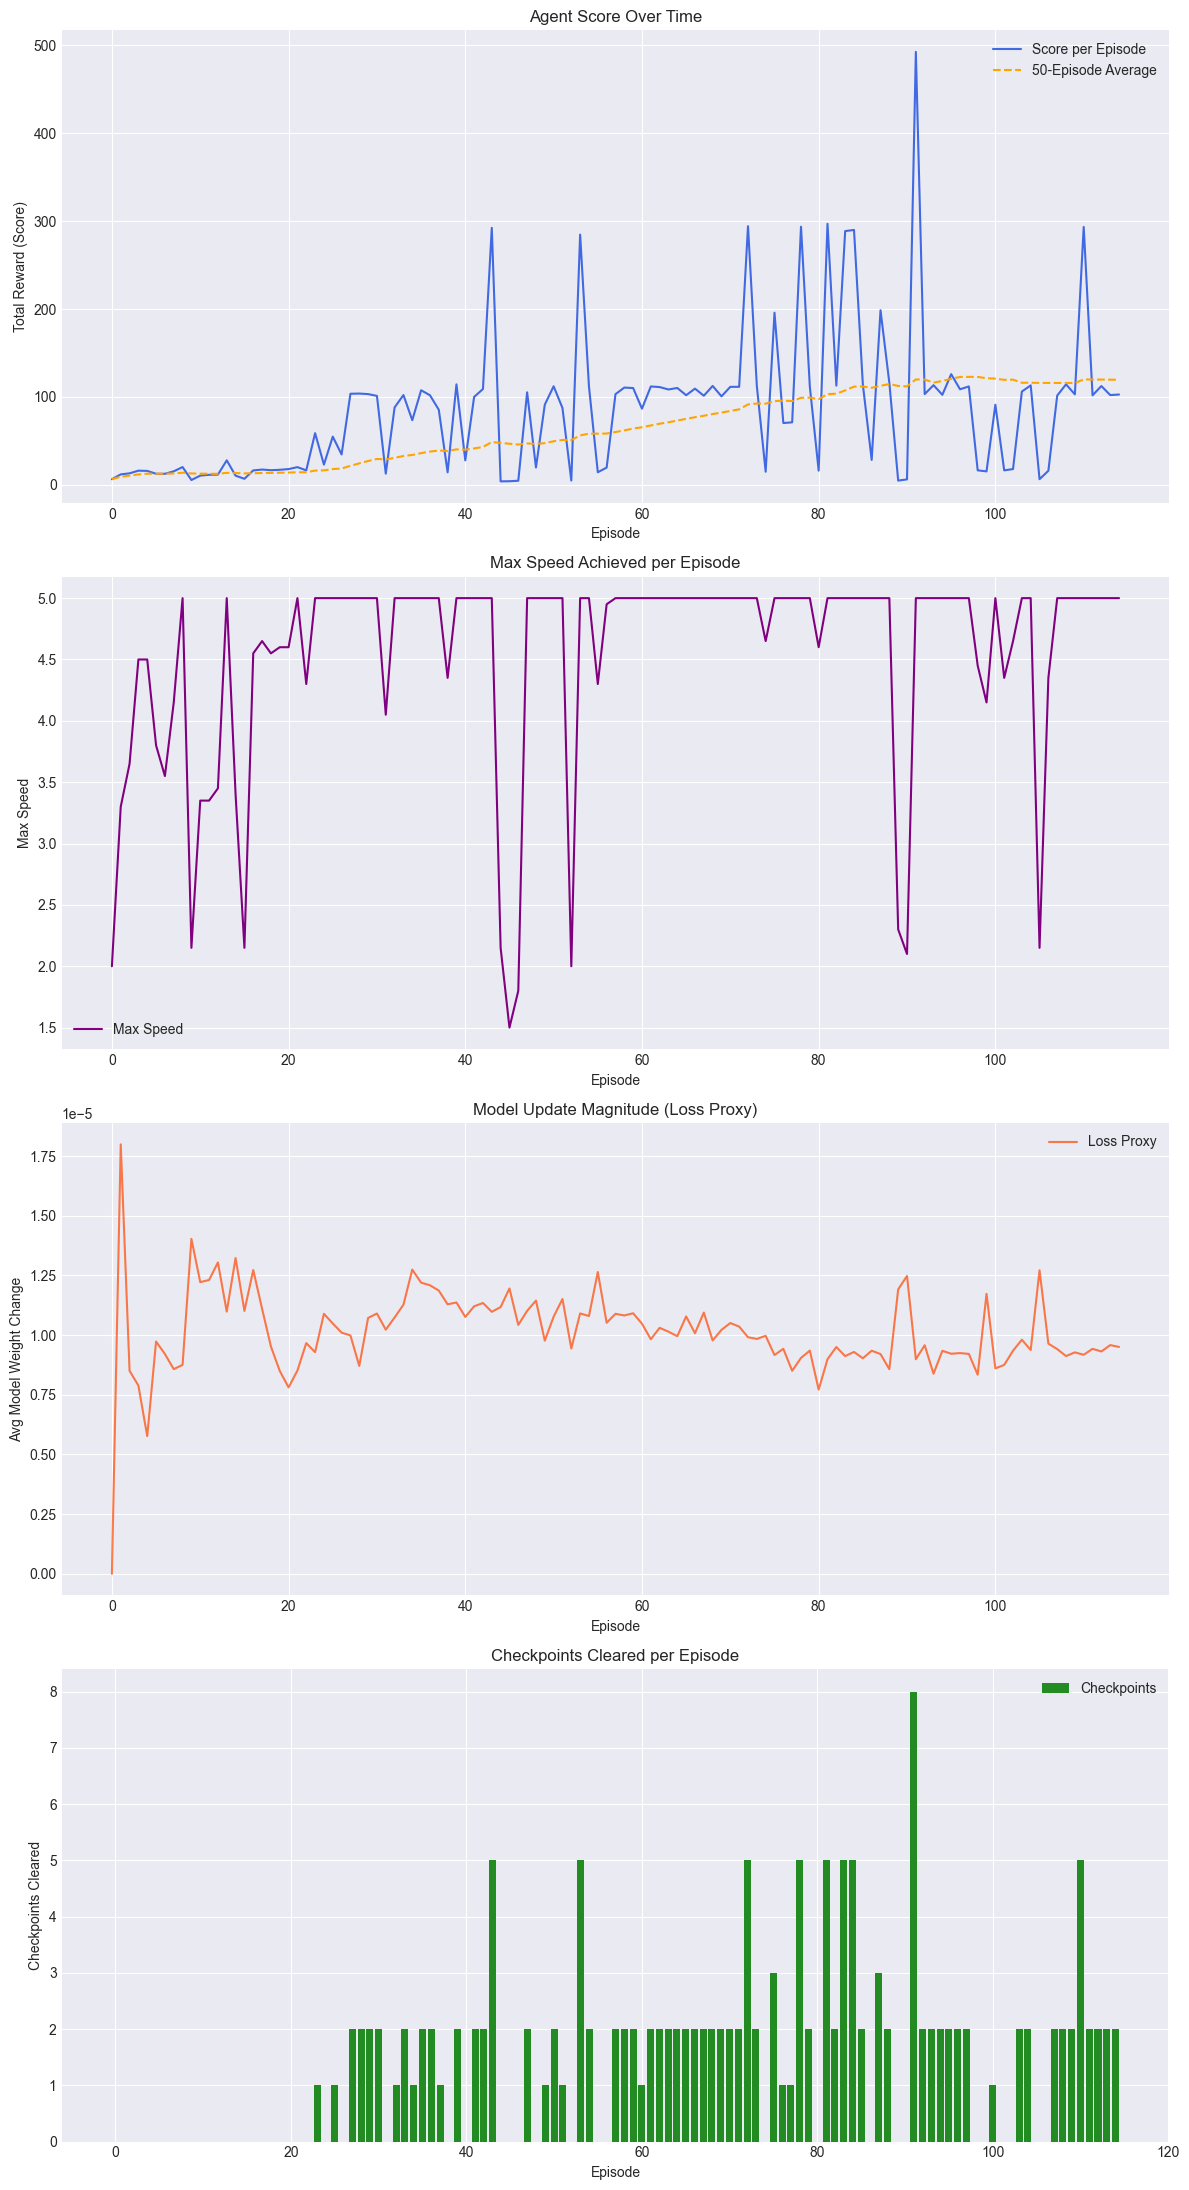

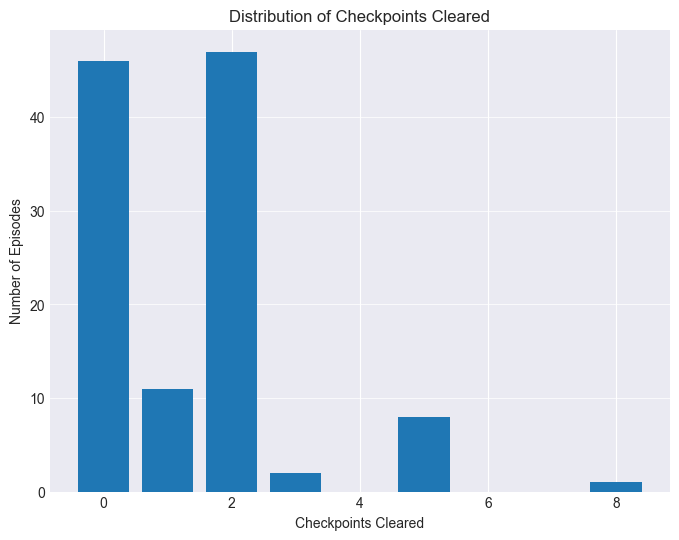

Episode 115/500 | Reward: 102.79 | Avg: 119.55 | Loss: 0.000010 | Max Speed: 5.00 | Epsilon: 0.050
Episode 116/500 | Reward: 15.68 | Avg: 117.82 | Loss: 0.000009 | Max Speed: 4.35 | Epsilon: 0.050
Episode 117/500 | Reward: 193.79 | Avg: 119.50 | Loss: 0.000010 | Max Speed: 5.00 | Epsilon: 0.050
Episode 118/500 | Reward: 111.70 | Avg: 119.71 | Loss: 0.000009 | Max Speed: 5.00 | Epsilon: 0.050
Episode 119/500 | Reward: 90.44 | Avg: 119.27 | Loss: 0.000010 | Max Speed: 5.00 | Epsilon: 0.050


IndexError: pixel index out of range

In [6]:

env = GameEnv(render_mode=False)  # headless mode
agent = D3QNAgent(state_size=env.state_size, action_size=env.action_size)

rewards, avg, losses, max_speed, checkpoints = train_agent(env, agent, episodes=500)
#test_scores = test_agent(env, agent, episodes=5, render=False)



In [7]:
env = GameEnv(render_mode=False)  # headless mode
agent = D3QNAgent(state_size=env.state_size, action_size=env.action_size)

test_scores = test_agent(env, agent, episodes=5, render=False)


Starting Evaluation Phase...

Episode 1: Reward = 3.52 | Steps = 29
Episode 2: Reward = 3.59 | Steps = 29
Episode 3: Reward = 3.59 | Steps = 29
Episode 4: Reward = 3.59 | Steps = 29
Episode 5: Reward = 3.59 | Steps = 29

 Avg Reward over 5 episodes: 3.57
